# Installations & Configuration

In [1]:
!pip install kaggle
!pip install tqdm

import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from google.colab import files
from torch.optim import Adam
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, average_precision_score


drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/ColabNotebooks/A5/kaggle.json'

# Copy kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp {kaggle_json_path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


# Data Setup

In [2]:
# Load Posters
!kaggle datasets download -d rezaunderfit/48k-imdb-movies-with-posters > /dev/null 2>&1
!unzip -q 48k-imdb-movies-with-posters.zip

# Load title basics
tsv_path = '/content/drive/MyDrive/ColabNotebooks/A5/title.basics.tsv'
title_basics = pd.read_csv(tsv_path, sep='\t', na_values='\\N')

# List all files in the Poster directory
poster_dir = 'Poster'
poster_files = []
for root, _, files in os.walk(poster_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            if os.path.getsize(file_path) > 0:  # Only include non-zero byte files
                poster_files.append(file_path)

# Extract tconst and startYear from file paths
poster_info = []
for file_path in poster_files:
    parts = file_path.split('/')
    start_year = parts[1]
    tconst = parts[2]
    poster_info.append((start_year, tconst))

# Convert to DataFrame
poster_df = pd.DataFrame(poster_info, columns=['startYear', 'tconst'])

# Ensure startYear is an integer
poster_df['startYear'] = poster_df['startYear'].astype(int)
title_basics['startYear'] = title_basics['startYear'].astype(float).fillna(0).astype(int)  # Handle missing startYear and convert to int

# Filter movies from the past 50 years
current_year = 2024
past_50_years = current_year - 50
poster_df = poster_df[poster_df['startYear'] >= past_50_years]

# Merge with title_basics to keep only relevant records
title_basics_filtered = pd.merge(title_basics, poster_df, on=['startYear', 'tconst'])

# Function to count genres
def count_genres(metadata):
    genre_counter = Counter()
    for genres in metadata['genres'].dropna():
        first_genre = genres.split(',')[0]
        genre_counter[first_genre] += 1
    return genre_counter

# Count genres in the filtered dataset
filtered_genre_counts = count_genres(title_basics_filtered)

# Calculate total number of movies
total_movies = len(title_basics_filtered)

# Filter out genres with less than 1% of the total dataset
min_count = total_movies * 0.01
valid_genres = {genre for genre, count in filtered_genre_counts.items() if count >= min_count}

# Filter the dataset to only include valid genres
def filter_genres(row):
    if pd.notna(row['genres']):
        genres = row['genres'].split(',')
        if any(genre in valid_genres for genre in genres):
            return True
    return False

title_basics_filtered = title_basics_filtered[title_basics_filtered.apply(filter_genres, axis=1)]

# Extract all unique genres and sort them to ensure consistent order
all_genres = sorted({genre for genres in title_basics_filtered['genres'].dropna() for genre in genres.split(',')})

# Create a consistent genre_to_index mapping
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

# Ensure 'Unknown' genre is included in genre_to_index
genre_to_index['Unknown'] = len(genre_to_index)

# Create your data splits
train_metadata, test_metadata = train_test_split(title_basics_filtered, test_size=0.2, random_state=42)
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, random_state=42)
print(f"Train size: {len(train_metadata)}, Validation size: {len(val_metadata)}, Test size: {len(test_metadata)}")

# Count genres in the training dataset
train_genre_counts = count_genres(train_metadata)

# Total number of movies in the training dataset
train_total_movies = len(train_metadata)

# Calculate and print genre distribution with percentages
print("\nGenre Distribution in Training Dataset:")
for genre, count in train_genre_counts.items():
    percentage = (count / train_total_movies) * 100
    print(f"{genre} - {count} ({percentage:.2f}%)")

# Define the image transformations
image_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MovieDataset(Dataset):
    def __init__(self, metadata, img_dir, transform=None, genre_to_index=None):
        self.metadata = metadata
        self.img_dir = img_dir
        self.transform = transform
        self.genre_to_index = genre_to_index

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        tconst = self.metadata.iloc[idx]['tconst']
        start_year = self.metadata.iloc[idx]['startYear']
        img_name = os.path.join(self.img_dir, str(start_year), tconst, f"{tconst}.jpg")
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        genres = self.metadata.iloc[idx]['genres']
        genre_tensor = self.genres_to_tensor(genres)
        return image, genre_tensor

    def genres_to_tensor(self, genres):
        first_genre = genres.split(',')[0] if pd.notna(genres) else 'Unknown'
        genre_index = self.genre_to_index.get(first_genre, self.genre_to_index['Unknown'])
        return torch.tensor(genre_index, dtype=torch.long)

# Directory containing images
img_dir = 'Poster'

# Create datasets
train_dataset = MovieDataset(metadata=train_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)
val_dataset = MovieDataset(metadata=val_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)
test_dataset = MovieDataset(metadata=test_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)


<ipython-input-2-af55b5ebbe7d>:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv(tsv_path, sep='\t', na_values='\\N')


Train size: 18474, Validation size: 6159, Test size: 6159

Genre Distribution in Training Dataset:
Documentary - 1363 (7.38%)
Adventure - 1127 (6.10%)
Comedy - 5020 (27.17%)
Action - 3388 (18.34%)
Crime - 1209 (6.54%)
Horror - 926 (5.01%)
Drama - 4034 (21.84%)
Biography - 941 (5.09%)
Adult - 8 (0.04%)
Fantasy - 79 (0.43%)
Animation - 378 (2.05%)
Family - 1 (0.01%)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Hyper Tuning via Optuna

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.trial import TrialState

def objective(trial):
    # hyperparameters values
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load pretrained model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    model.aux_logits = False
    num_genres = len(genre_to_index)
    model.fc = nn.Linear(model.fc.in_features, num_genres)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    num_epochs = 5  # Reduced number of epochs for hyperparameter tuning
    best_val_loss = float('inf')
    patience = 2  # Early stopping patience
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, genres in train_loader:
            images = images.to(device)
            genres = genres.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, genres)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_images, val_genres in val_loader:
                val_images = val_images.to(device)
                val_genres = val_genres.to(device)
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_genres).item()

        val_loss /= len(val_loader)
        trial.report(val_loss, epoch)

        # Pruning
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    return best_val_loss

# Create the study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)  # Set a timeout to limit the total tuning time

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Transfer Learning --> Fine Tuning (Training & Validation)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s] 
Epoch 1/5: 100%|██████████| 578/578 [04:27<00:00,  2.16batch

Epoch [1/5], Training Loss: 1.831272188354941, Validation Loss: 1.7607955352012357


Epoch 2/5: 100%|██████████| 578/578 [04:31<00:00,  2.13batch/s]


Epoch [2/5], Training Loss: 1.7254071594522074, Validation Loss: 1.7517032715940724


Epoch 3/5: 100%|██████████| 578/578 [04:31<00:00,  2.13batch/s]


Epoch [3/5], Training Loss: 1.681782963779146, Validation Loss: 1.740675096684787


Epochs:  80%|████████  | 4/5 [21:00<05:13, 313.86s/epoch]

Epoch [4/5], Training Loss: 1.6450682220574482, Validation Loss: 1.7662594781638428



Epochs: 100%|██████████| 5/5 [26:14<00:00, 314.92s/epoch]

Epoch [5/5], Training Loss: 1.6041545655488143, Validation Loss: 1.754938958840049
Training complete.


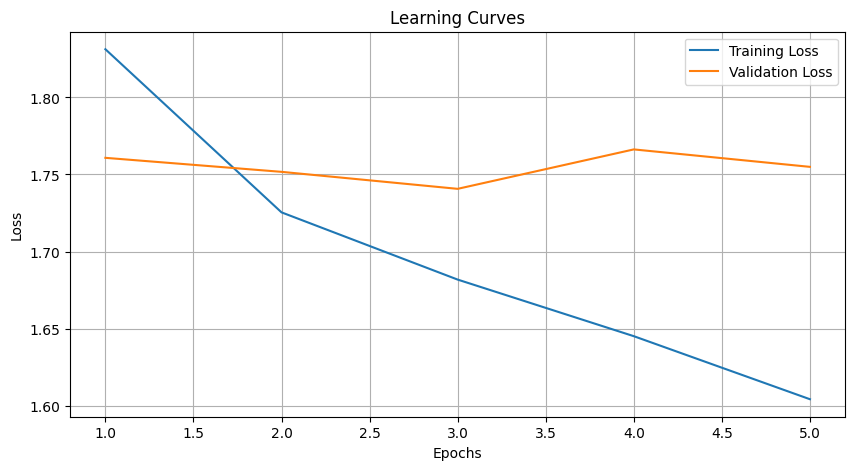

<Figure size 640x480 with 0 Axes>

In [3]:
# Best Hyperparameters After Grid Search
batch_size = 32
lr = 0.001 # 2.9829823735090913e-05
weight_decay = 7.167993883340144e-06
num_epochs = 5

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Set up model for fine tuning
model = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", pretrained=True)
model.aux_logits = False  # Disable auxiliary logits
num_genres = len(genre_to_index)
model.fc = nn.Linear(model.fc.in_features, num_genres)  # Adjust the final layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Lists to store losses
train_losses = []
val_losses = []

# Training loop with validation
best_val_loss = float("inf")

for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"
    )

    for images, genres in train_loader_tqdm:
        images = images.to(device)
        genres = genres.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, genres)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_genres in val_loader:
            val_images = val_images.to(device)
            val_genres = val_genres.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_genres).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss}, Validation Loss: {val_loss}"
    )

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            model.state_dict(),
            "/content/drive/MyDrive/ColabNotebooks/A5/best_model_inception.pth",
        )

print("Training complete.")

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("/content/drive/MyDrive/ColabNotebooks/A5/inceptionv3_learning_curves.png")

# Transfer Learning --> Fine Tuning (Testing)

Testing: 100%|██████████| 193/193 [00:41<00:00,  4.66batch/s]


Test Loss: 1.7217482377828095, Test Accuracy: 0.3932456567624614
Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8 10 12]
Labels in genre_to_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Missing labels in genre_to_index: set()
Extra labels in genre_to_index: {9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


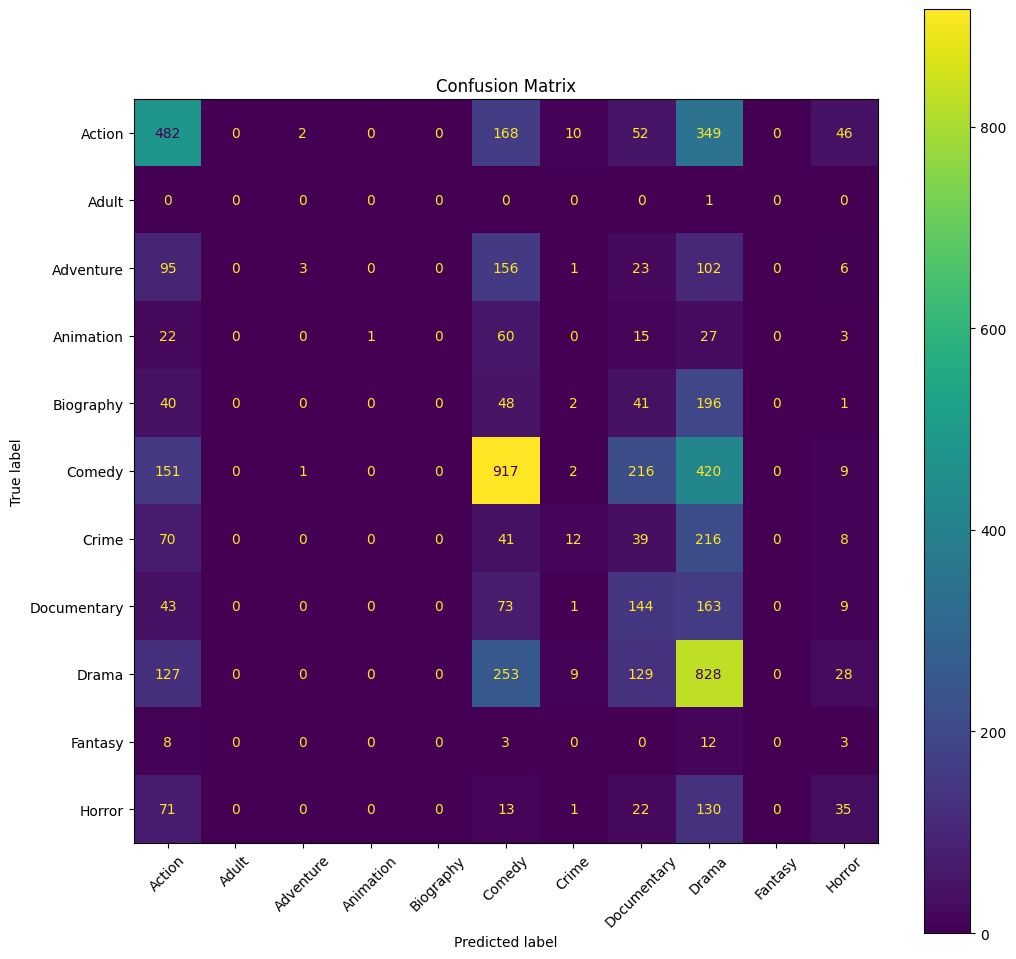

Classification Report:
              precision    recall  f1-score   support

      Action       0.43      0.43      0.43      1109
       Adult       0.00      0.00      0.00         1
   Adventure       0.50      0.01      0.02       386
   Animation       1.00      0.01      0.02       128
   Biography       0.00      0.00      0.00       328
      Comedy       0.53      0.53      0.53      1716
       Crime       0.32      0.03      0.06       386
 Documentary       0.21      0.33      0.26       433
       Drama       0.34      0.60      0.43      1374
     Fantasy       0.00      0.00      0.00        26
      Horror       0.24      0.13      0.17       272

    accuracy                           0.39      6159
   macro avg       0.32      0.19      0.17      6159
weighted avg       0.40      0.39      0.35      6159

F1 Scores:
Action: 0.43
Adult: 0.00
Adventure: 0.02
Animation: 0.02
Biography: 0.00
Comedy: 0.53
Crime: 0.06
Documentary: 0.26
Drama: 0.43
Fantasy: 0.00
Horror: 0.1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<Figure size 640x480 with 0 Axes>

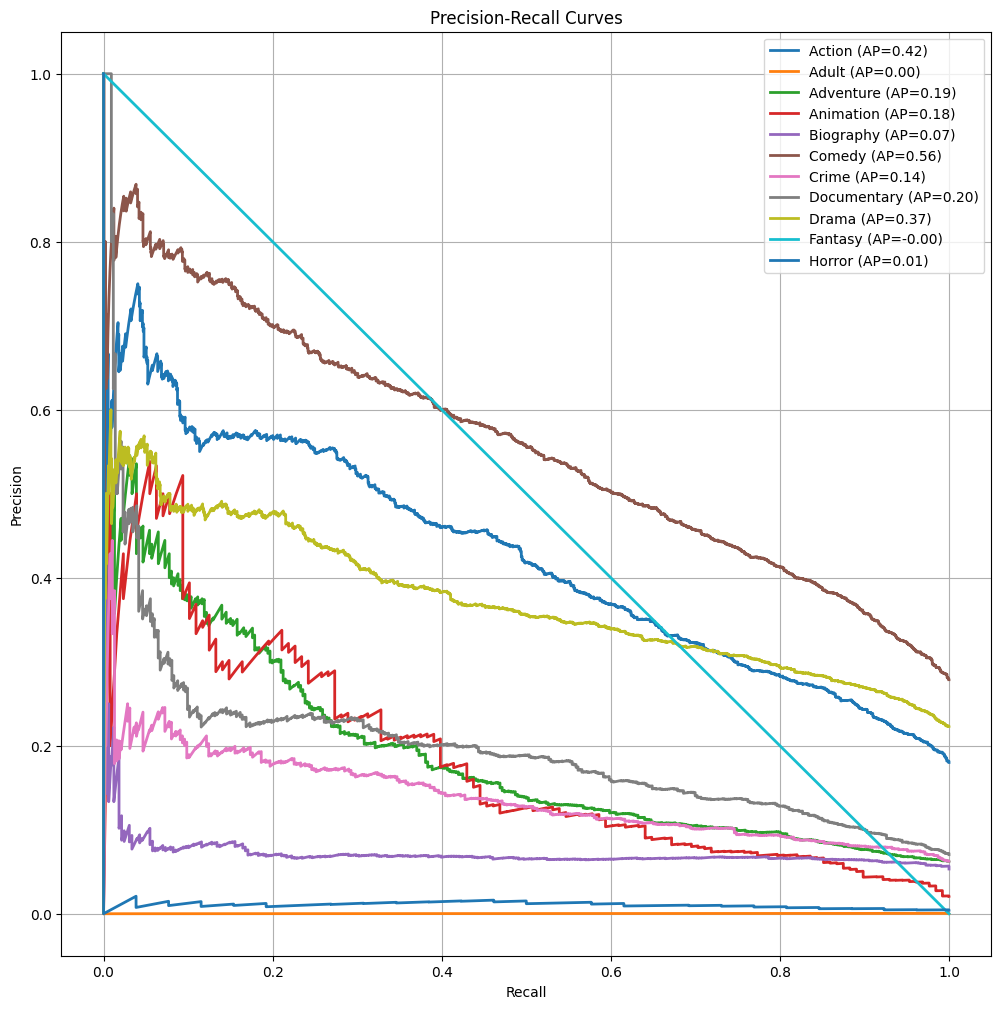

<Figure size 640x480 with 0 Axes>

In [4]:
# Helper function to print unique labels
def print_unique_labels(all_labels, genre_to_index):
    unique_labels_in_data = np.unique(all_labels)
    print("Unique labels in the dataset:", unique_labels_in_data)
    print("Labels in genre_to_index:", list(genre_to_index.values()))

    missing_labels = set(unique_labels_in_data) - set(genre_to_index.values())
    extra_labels = set(genre_to_index.values()) - set(unique_labels_in_data)
    print("Missing labels in genre_to_index:", missing_labels)
    print("Extra labels in genre_to_index:", extra_labels)


# Load the best model
model.load_state_dict(
    torch.load("/content/drive/MyDrive/ColabNotebooks/A5/best_model_inception.pth")
)

# Evaluate on test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Testing", unit="batch")
    for test_images, test_genres in test_loader_tqdm:
        test_images = test_images.to(device)
        test_genres = test_genres.to(device)
        test_outputs = model(test_images)
        test_loss += criterion(test_outputs, test_genres).item()
        _, predicted = torch.max(test_outputs, 1)
        total += test_genres.size(0)
        correct += (predicted == test_genres).sum().item()

        # Collect all predictions, true labels, and probabilities for precision-recall curves
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(test_genres.cpu().numpy())
        all_probs.extend(torch.softmax(test_outputs, dim=1).cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Print unique labels and find mismatches
print_unique_labels(all_labels, genre_to_index)

# Adjust the genre_to_index dictionary if necessary
# Remove unused labels
used_labels = sorted(np.unique(all_labels))
genre_to_index = {
    genre: idx for genre, idx in genre_to_index.items() if idx in used_labels
}

# Ensure the number of classes matches the labels
assert len(genre_to_index) == len(
    np.unique(all_labels)
), "Mismatch in number of genres and labels."

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(genre_to_index.keys())
)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()
plt.savefig("/content/drive/MyDrive/ColabNotebooks/A5/inceptionv3_confusion_matrix.png")

# Print classification report with F1 score
print("Classification Report:")
report = classification_report(
    all_labels, all_preds, target_names=list(genre_to_index.keys()), output_dict=True
)
print(
    classification_report(
        all_labels, all_preds, target_names=list(genre_to_index.keys())
    )
)

# Extract and print the F1 score
f1_scores = {genre: report[genre]["f1-score"] for genre in genre_to_index.keys()}
print("F1 Scores:")
for genre, f1 in f1_scores.items():
    print(f"{genre}: {f1:.2f}")

# Plot precision-recall curves for each genre
plt.figure(figsize=(12, 12))
for i, genre in enumerate(genre_to_index.keys()):
    precision, recall, _ = precision_recall_curve(
        np.array(all_labels) == i, np.array(all_probs)[:, i]
    )
    average_precision = average_precision_score(
        np.array(all_labels) == i, np.array(all_probs)[:, i]
    )
    plt.plot(recall, precision, lw=2, label=f"{genre} (AP={average_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="best")
plt.grid(True)
plt.show()
plt.savefig(
    "/content/drive/MyDrive/ColabNotebooks/A5/inceptionv3_precision_recall_curves.png"
)